In [1]:
#Importing Libraries <a name="Importing-Libraries"></a>
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import networkx as nx
from sklearn.cluster import SpectralClustering # For graph clustering alternative
from tqdm.notebook import tqdm # Progress bars
import os
import gc # Garbage collection for memory management
from collections import defaultdict
import time

print("Libraries imported.")
print(f"OpenCV version: {cv2.__version__}")
print(f"NetworkX version: {nx.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")

Libraries imported.
OpenCV version: 4.11.0
NetworkX version: 3.4.2
Pandas version: 2.2.3
Numpy version: 1.26.4


In [2]:
#  Defining Constants and Paths <a name="Defining-Constants"></a>

# Determine if running in Kaggle environment and set paths accordingly
IS_KAGGLE = os.path.exists('/kaggle/input')
if IS_KAGGLE:
    DATA_DIR = Path('/kaggle/input/image-matching-challenge-2025/')
    OUTPUT_DIR = Path('/kaggle/working/')
    # For submission, the test directory might be different, handled later
    TEST_DIR_PUBLIC = DATA_DIR / 'test' # Public test for code dev
else:
    # Set local paths if running outside Kaggle
    DATA_DIR = Path('./data/') # Adjust this to your local data path
    TEST_DIR_PUBLIC = DATA_DIR / 'test'
    OUTPUT_DIR = Path('./output/')
    OUTPUT_DIR.mkdir(exist_ok=True)

TRAIN_DIR = DATA_DIR / 'train'

# --- Feature Extraction Parameters ---
# Options: 'SIFT', 'AKAZE', 'ORB' (DISK/ALIKED need external setup)
FEATURE_EXTRACTOR_TYPE = 'SIFT'
SIFT_NFEATURES = 8000 # Max features per image for SIFT

# --- Matching Parameters ---
MATCHER_TYPE = 'FLANN' # 'BF' (Brute Force) or 'FLANN' (Fast Library for Approximate Nearest Neighbors)
LOWE_RATIO_TEST_THRESHOLD = 0.8 # For filtering good matches (knnMatch ratio)
MIN_INLIER_MATCHES_INITIAL = 15 # Min inliers for initial pairwise geometry check
MIN_INLIER_MATCHES_GRAPH = 10 # Min inliers to add edge to view graph (can be lower)

# --- Geometric Verification (RANSAC for Fundamental Matrix) ---
RANSAC_THRESHOLD = 1.5 # RANSAC reprojection threshold in pixels for findFundamentalMat

# --- Clustering Parameters ---
# Options: 'ConnectedComponents', 'Spectral'
CLUSTERING_ALGORITHM = 'ConnectedComponents'
MIN_CLUSTER_SIZE = 3 # Minimum images to form a valid scene cluster

# --- SfM Parameters ---
MIN_VIEWS_FOR_TRIANGULATION = 2 # Need at least two views for triangulation
PNP_RANSAC_THRESHOLD = 5.0 # RANSAC reprojection threshold for solvePnPRansac
PNP_CONFIDENCE = 0.999 # Confidence for PnPRansac
MIN_3D_POINTS_FOR_PNP = 6 # Minimum 3D points required for PnP

# --- Camera Intrinsics (Approximation - Not submitted, but needed for E/PnP) ---
# We estimate a default K matrix. Real K varies per image, but this is a common
# simplification if intrinsics aren't provided or estimated.
# Focal length is often approximated based on image width.
DEFAULT_FOCAL_LENGTH_FACTOR = 1.2
# Assuming cx, cy are image center. Will be calculated per image later.

# --- Submission Runtime Control ---
MAX_RUNTIME_SECONDS = 8.5 * 3600 # Slightly less than 9 hours Kaggle limit
START_TIME = time.time()

print(f"Constants defined. Using {FEATURE_EXTRACTOR_TYPE} features and {MATCHER_TYPE} matcher.")
print(f"Running in {'Kaggle' if IS_KAGGLE else 'Local'} environment.")
print(f"Data Directory: {DATA_DIR}")

Constants defined. Using SIFT features and FLANN matcher.
Running in Kaggle environment.
Data Directory: /kaggle/input/image-matching-challenge-2025


In [3]:
# Loading Competition Metadata <a name="Loading-Metadata"></a>
try:
    train_labels_df = pd.read_csv(DATA_DIR / 'train_labels.csv')
    train_thresholds_df = pd.read_csv(DATA_DIR / 'train_thresholds.csv')
    sample_submission_df = pd.read_csv(DATA_DIR / 'sample_submission.csv')

    print("--- Train Labels Info ---")
    train_labels_df.info()
    print(f"\nLoaded {len(train_labels_df)} training labels.")
    print(train_labels_df.head())

    print("\n--- Train Thresholds Info ---")
    train_thresholds_df.info()
    print(f"Loaded {len(train_thresholds_df)} training thresholds.")
    print(train_thresholds_df.head())

    print("\n--- Sample Submission Info ---")
    sample_submission_df.info()
    print(f"Loaded {len(sample_submission_df)} sample submission rows.")
    print(sample_submission_df.head())

except FileNotFoundError as e:
    print(f"Error loading metadata: {e}")
    print("Please ensure the data is correctly placed in the DATA_DIR.")
    # Handle error appropriately, maybe exit or use dummy data if developing
    if IS_KAGGLE: # If in Kaggle and files are missing, it's a problem
        raise e
    else: # If local, maybe we proceed with dummy data for structure testing
        print("Proceeding without metadata (for structure testing only).")
        train_labels_df = pd.DataFrame() # Dummy dataframes
        train_thresholds_df = pd.DataFrame()
        sample_submission_df = pd.DataFrame()

--- Train Labels Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1945 entries, 0 to 1944
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   dataset             1945 non-null   object
 1   scene               1945 non-null   object
 2   image               1945 non-null   object
 3   rotation_matrix     1945 non-null   object
 4   translation_vector  1945 non-null   object
dtypes: object(5)
memory usage: 76.1+ KB

Loaded 1945 training labels.
          dataset     scene                   image  \
0  imc2023_haiper  fountain  fountain_image_116.png   
1  imc2023_haiper  fountain  fountain_image_108.png   
2  imc2023_haiper  fountain  fountain_image_101.png   
3  imc2023_haiper  fountain  fountain_image_082.png   
4  imc2023_haiper  fountain  fountain_image_071.png   

                                     rotation_matrix  \
0  0.122655949;0.947713775;-0.294608417;0.1226706...   
1  0.474305910;0.3

In [4]:
#  Understanding the Data Structure <a name="Data-Structure"></a>
if not train_labels_df.empty:
    datasets_train = train_labels_df['dataset'].unique()
    print(f"Training datasets ({len(datasets_train)}): {datasets_train}")

    # List subdirectories in train and test (public)
    train_folders = [f.name for f in TRAIN_DIR.iterdir() if f.is_dir()]
    print(f"\nFolders in {TRAIN_DIR} ({len(train_folders)}): {train_folders}")

    if TEST_DIR_PUBLIC.exists():
        test_folders = [f.name for f in TEST_DIR_PUBLIC.iterdir() if f.is_dir()]
        print(f"\nFolders in {TEST_DIR_PUBLIC} ({len(test_folders)}): {test_folders}")
    else:
        print(f"\nPublic test directory {TEST_DIR_PUBLIC} not found.")

else:
    print("Skipping EDA as training labels are not loaded.")

Training datasets (13): ['imc2023_haiper' 'imc2023_heritage' 'imc2023_theather_imc2024_church'
 'imc2024_dioscuri_baalshamin' 'imc2024_lizard_pond'
 'pt_brandenburg_british_buckingham' 'pt_piazzasanmarco_grandplace'
 'pt_sacrecoeur_trevi_tajmahal' 'pt_stpeters_stpauls' 'amy_gardens'
 'fbk_vineyard' 'ETs' 'stairs']

Folders in /kaggle/input/image-matching-challenge-2025/train (13): ['amy_gardens', 'ETs', 'pt_brandenburg_british_buckingham', 'fbk_vineyard', 'pt_stpeters_stpauls', 'pt_piazzasanmarco_grandplace', 'imc2023_heritage', 'imc2024_dioscuri_baalshamin', 'pt_sacrecoeur_trevi_tajmahal', 'imc2023_theather_imc2024_church', 'imc2024_lizard_pond', 'imc2023_haiper', 'stairs']

Folders in /kaggle/input/image-matching-challenge-2025/test (2): ['ETs', 'stairs']



--- Scenes per Dataset (including 'outliers' as a scene) ---
dataset
ETs                                  3
amy_gardens                          1
fbk_vineyard                         3
imc2023_haiper                       3
imc2023_heritage                     4
imc2023_theather_imc2024_church      2
imc2024_dioscuri_baalshamin          3
imc2024_lizard_pond                  3
pt_brandenburg_british_buckingham    3
pt_piazzasanmarco_grandplace         2
pt_sacrecoeur_trevi_tajmahal         3
pt_stpeters_stpauls                  2
stairs                               2
Name: scene, dtype: int64

--- Statistics on Images per Scene (excluding outliers) ---
count     30.000000
mean      60.766667
std       39.293488
min        9.000000
25%       28.500000
50%       66.500000
75%       75.000000
max      200.000000
Name: image_count, dtype: float64

--- Outlier Images per Dataset ---
dataset
ETs                             3
imc2023_heritage               61
imc2024_dioscuri_baalshamin   

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


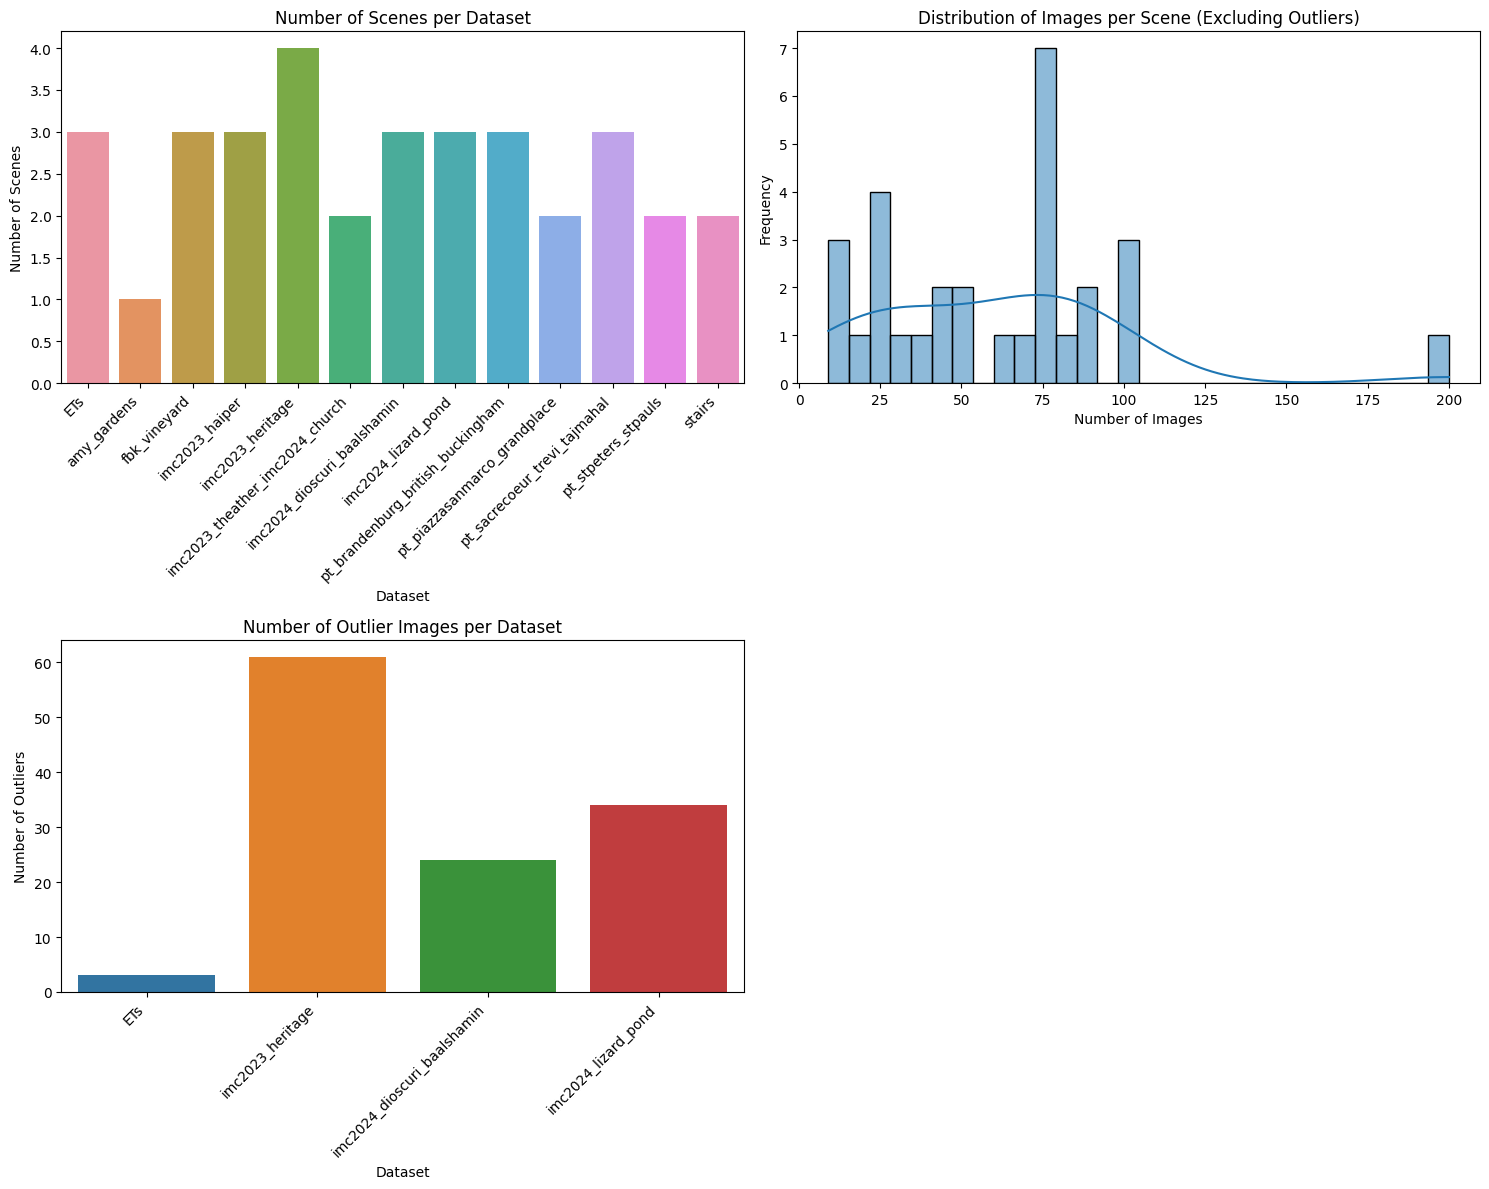

In [5]:
# Analyzing Training Labels <a name="Analyzing-Labels"></a>
if not train_labels_df.empty:
    # Calculate scenes per dataset
    scenes_per_dataset = train_labels_df.groupby('dataset')['scene'].nunique()
    # Calculate images per scene (excluding outliers for distribution stats)
    images_per_scene = train_labels_df[train_labels_df['scene'] != 'outliers'].groupby(['dataset', 'scene']).size().reset_index(name='image_count')
    # Outlier counts per dataset
    outliers_per_dataset = train_labels_df[train_labels_df['scene'] == 'outliers'].groupby('dataset').size()

    print("\n--- Scenes per Dataset (including 'outliers' as a scene) ---")
    print(scenes_per_dataset)

    print("\n--- Statistics on Images per Scene (excluding outliers) ---")
    print(images_per_scene['image_count'].describe())

    print("\n--- Outlier Images per Dataset ---")
    print(outliers_per_dataset)

    # Plotting
    plt.figure(figsize=(15, 12))

    plt.subplot(2, 2, 1)
    sns.barplot(x=scenes_per_dataset.index, y=scenes_per_dataset.values)
    plt.title('Number of Scenes per Dataset')
    plt.xlabel('Dataset')
    plt.ylabel('Number of Scenes')
    plt.xticks(rotation=45, ha='right')

    plt.subplot(2, 2, 2)
    sns.histplot(images_per_scene['image_count'], bins=30, kde=True)
    plt.title('Distribution of Images per Scene (Excluding Outliers)')
    plt.xlabel('Number of Images')
    plt.ylabel('Frequency')
    plt.tight_layout()

    plt.subplot(2, 2, 3)
    if not outliers_per_dataset.empty:
        sns.barplot(x=outliers_per_dataset.index, y=outliers_per_dataset.values)
        plt.title('Number of Outlier Images per Dataset')
        plt.xlabel('Dataset')
        plt.ylabel('Number of Outliers')
        plt.xticks(rotation=45, ha='right')
    else:
        plt.text(0.5, 0.5, 'No Outliers Found', ha='center', va='center')
        plt.title('Outlier Images per Dataset')


    plt.tight_layout()
    plt.show()

else:
    print("Skipping label analysis as training labels are not loaded.")

Scenes in imc2024_lizard_pond: ['lizard' 'outliers' 'pond']


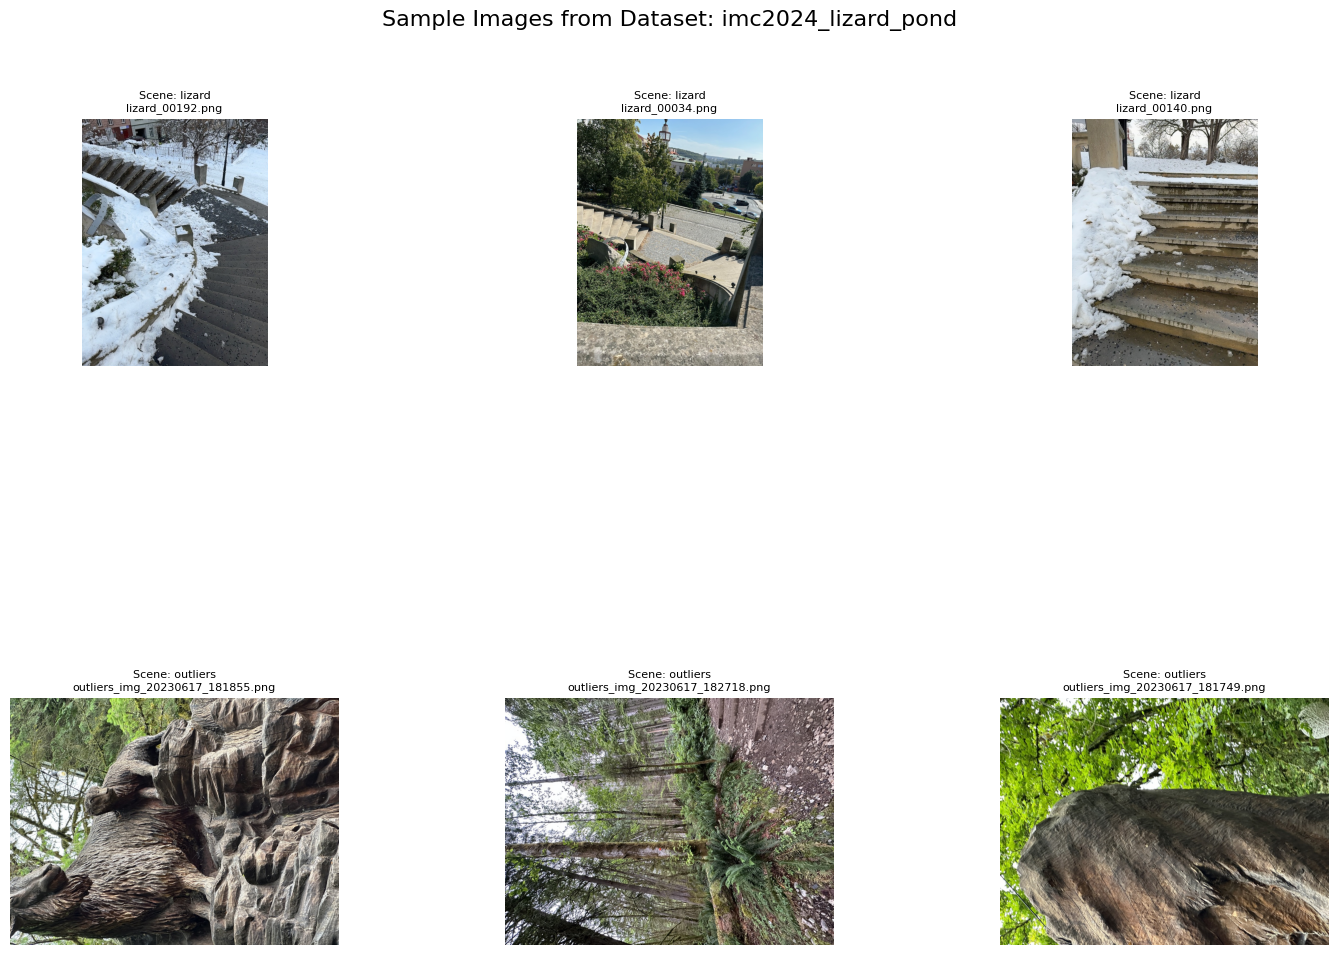

In [6]:
# Visualizing Image Samples <a name="Visualizing-Samples"></a>
# Function to display sample images from a dataset
def display_dataset_samples(dataset_name, n_scenes_to_show=2, n_samples_per_scene=3):
    if train_labels_df.empty:
        print("Cannot display samples without train_labels_df.")
        return

    dataset_labels = train_labels_df[train_labels_df['dataset'] == dataset_name]
    if dataset_labels.empty:
        print(f"No labels found for dataset: {dataset_name}")
        return

    scenes = dataset_labels['scene'].unique()
    print(f"Scenes in {dataset_name}: {scenes}")

    plt.figure(figsize=(15, 5 * n_scenes_to_show))
    plot_idx = 1

    # Show samples from regular scenes
    regular_scenes = [s for s in scenes if s != 'outliers'][:n_scenes_to_show]
    for scene in regular_scenes:
        scene_images = dataset_labels[dataset_labels['scene'] == scene]['image'].sample(min(n_samples_per_scene, len(dataset_labels[dataset_labels['scene'] == scene]))).tolist()
        for img_name in scene_images:
            img_path = TRAIN_DIR / dataset_name / img_name
            if img_path.exists():
                img = cv2.imread(str(img_path))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                ax = plt.subplot(n_scenes_to_show + 1, n_samples_per_scene, plot_idx) # +1 for outliers row
                ax.imshow(img)
                ax.set_title(f"Scene: {scene}\n{img_name}", fontsize=8)
                ax.axis('off')
            plot_idx += 1
        # Fill remaining plots in the row if fewer samples found
        plot_idx = ( (plot_idx -1) // n_samples_per_scene + 1) * n_samples_per_scene + 1


    # Show samples from outliers if they exist
    if 'outliers' in scenes:
         outlier_images = dataset_labels[dataset_labels['scene'] == 'outliers']['image'].sample(min(n_samples_per_scene, len(dataset_labels[dataset_labels['scene'] == 'outliers']))).tolist()
         # Adjust starting plot index for outlier row
         plot_idx = n_scenes_to_show * n_samples_per_scene + 1
         for img_name in outlier_images:
             img_path = TRAIN_DIR / dataset_name / 'outliers' / img_name # Check specific outlier folder if structure dictates
             # Fallback to main folder if outlier folder doesn't exist or image isn't there
             if not img_path.exists():
                 img_path = TRAIN_DIR / dataset_name / img_name

             if img_path.exists():
                 img = cv2.imread(str(img_path))
                 img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                 ax = plt.subplot(n_scenes_to_show + 1, n_samples_per_scene, plot_idx)
                 ax.imshow(img)
                 ax.set_title(f"Scene: outliers\n{img_name}", fontsize=8)
                 ax.axis('off')
             plot_idx += 1


    plt.suptitle(f"Sample Images from Dataset: {dataset_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

# Display samples from a dataset known to have multiple scenes/outliers
if not train_labels_df.empty:
    example_dataset = 'imc2024_lizard_pond' # Choose a dataset from EDA
    if example_dataset in train_labels_df['dataset'].unique():
         display_dataset_samples(example_dataset)
    else:
        print(f"Example dataset '{example_dataset}' not found in labels. Choose another.")
        if len(datasets_train)>0:
             display_dataset_samples(datasets_train[0]) # Show first dataset if example not found
else:
    print("Skipping visualization as training labels are not loaded.")

In [7]:
# Feature Extraction Function <a name="Feature-Extraction-Function"></a>

def get_feature_extractor(extractor_type='SIFT'):
    """Creates the specified OpenCV feature extractor."""
    if extractor_type == 'SIFT':
        return cv2.SIFT_create(nfeatures=SIFT_NFEATURES)
    elif extractor_type == 'AKAZE':
        # AKAZE needs descriptors of size 61*8 = 488 bits
        return cv2.AKAZE_create()
    elif extractor_type == 'ORB':
        return cv2.ORB_create(nfeatures=SIFT_NFEATURES) # Use same nfeatures param for consistency
    # Add other types like BRISK if needed
    else:
        raise ValueError(f"Unsupported feature extractor type: {extractor_type}")

def extract_features(image_path, extractor):
    """Extracts keypoints and descriptors from an image file."""
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Warning: Could not read image {image_path}")
        return None, None, (None, None)

    # Check if image dimensions are too small (might cause issues)
    h, w = img.shape
    if h < 20 or w < 20: # Example threshold
        # print(f"Warning: Image {image_path} is very small ({w}x{h}), skipping feature extraction.")
        return None, None, (w,h)


    kps, descs = extractor.detectAndCompute(img, None)

    if kps is None or descs is None or len(kps) == 0:
         # print(f"Warning: No features found for image {image_path}")
         return None, None, (w,h)

    # Convert keypoints to a standard format if needed (e.g., for serialization)
    # kps_tuples = [(kp.pt, kp.size, kp.angle, kp.response, kp.octave, kp.class_id) for kp in kps]
    # For direct use with OpenCV, keep the original KeyPoint objects
    return kps, descs, (w, h) # Return image dimensions as well

def load_and_extract_features_dataset(dataset_id, dataset_base_path, extractor):
    """Loads all images for a dataset and extracts features."""
    features = {}
    image_dims = {}
    dataset_path = dataset_base_path / dataset_id
    image_files = list(dataset_path.glob('*.png')) + list(dataset_path.glob('*.jpg')) + list(dataset_path.glob('*.jpeg'))

    # Handle potential 'outliers' subdirectory - check if needed based on actual data structure
    outlier_path = dataset_path / 'outliers'
    if outlier_path.is_dir():
        print(f"Including images from outliers subdirectory for {dataset_id}")
        image_files.extend(list(outlier_path.glob('*.png')) + list(outlier_path.glob('*.jpg')) + list(outlier_path.glob('*.jpeg')))


    print(f"Extracting features for {len(image_files)} images in dataset {dataset_id}...")
    for img_path in tqdm(image_files, desc=f"Features {dataset_id}"):
        image_id = img_path.name # Use filename as unique ID within dataset
        kps, descs, dims = extract_features(img_path, extractor)
        if kps is not None and descs is not None:
            features[image_id] = (kps, descs)
            image_dims[image_id] = dims
        else:
             # Store dims even if features failed, might be needed for K matrix
             if dims[0] is not None:
                 image_dims[image_id] = dims

    return features, image_dims


# Example Usage (can be commented out during full run)
# sift = get_feature_extractor(FEATURE_EXTRACTOR_TYPE)
# example_img_path = next((TRAIN_DIR / 'imc2024_lizard_pond').glob('*.png'), None) # Get one image
# if example_img_path:
#     kps, descs, dims = extract_features(example_img_path, sift)
#     if kps:
#         print(f"Extracted {len(kps)} features from {example_img_path.name}")
#         img_bgr = cv2.imread(str(example_img_path))
#         img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
#         img_kps = cv2.drawKeypoints(img_rgb, kps, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#         plt.figure(figsize=(10, 7))
#         plt.imshow(img_kps)
#         plt.title(f"Features ({FEATURE_EXTRACTOR_TYPE}) on {example_img_path.name}")
#         plt.axis('off')
#         plt.show()
# else:
#     print("Could not find an example image for feature extraction demo.")


In [8]:
#  Matching and Verification Function <a name="Matching-Function"></a>

def get_matcher(matcher_type='FLANN', extractor_type='SIFT'):
    """Creates the specified OpenCV feature matcher."""
    if matcher_type == 'BF':
        # Use appropriate norm type based on descriptor
        if extractor_type in ['SIFT', 'SURF']: # SURF is patented, usually avoid
             norm_type = cv2.NORM_L2
        elif extractor_type in ['ORB', 'BRISK', 'AKAZE']: # Binary descriptors
             norm_type = cv2.NORM_HAMMING
        else: # Default assumption
             norm_type = cv2.NORM_L2
        return cv2.BFMatcher(norm_type, crossCheck=False) # Use crossCheck=False for knnMatch

    elif matcher_type == 'FLANN':
        # FLANN parameters depend on descriptor type
        if extractor_type in ['SIFT', 'SURF']:
            # FLANN_INDEX_KDTREE = 1
            index_params = dict(algorithm=1, trees=5)
            search_params = dict(checks=50) # or pass empty dictionary
        elif extractor_type in ['ORB', 'BRISK', 'AKAZE']:
            # FLANN_INDEX_LSH = 6
            # Parameters are tuned for ORB, may need adjustment for others
            index_params= dict(algorithm = 6,
                               table_number = 6, # 12
                               key_size = 12,     # 20
                               multi_probe_level = 1) # 2
            search_params = dict(checks=50) # or pass empty dict
        else:
             raise ValueError(f"FLANN parameters not defined for extractor type: {extractor_type}")
        return cv2.FlannBasedMatcher(index_params, search_params)
    else:
        raise ValueError(f"Unsupported matcher type: {matcher_type}")


def match_and_verify(kps1, descs1, kps2, descs2, matcher):
    """Matches features and verifies geometry using Fundamental Matrix RANSAC."""
    if descs1 is None or descs2 is None or len(kps1) < MIN_INLIER_MATCHES_INITIAL or len(kps2) < MIN_INLIER_MATCHES_INITIAL :
        return None, 0 # Not enough keypoints

    # Perform k-Nearest Neighbor matching
    matches = matcher.knnMatch(descs1, descs2, k=2)

    # Filter matches using Lowe's ratio test
    good_matches = []
    try:
        for m, n in matches:
            if m.distance < LOWE_RATIO_TEST_THRESHOLD * n.distance:
                good_matches.append(m)
    except ValueError:
         # Handle cases where k=1 match is returned (e.g., if descs2 has only 1 feature)
         # print("Warning: knnMatch did not return pairs, possibly too few features in one image.")
         return None, 0


    if len(good_matches) < MIN_INLIER_MATCHES_INITIAL:
        # print(f"Insufficient good matches after ratio test: {len(good_matches)}")
        return None, 0 # Not enough good matches

    # Extract locations of good matches
    pts1 = np.float32([kps1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    pts2 = np.float32([kps2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Find Fundamental Matrix using RANSAC
    try:
        F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, RANSAC_THRESHOLD, confidence=0.99)
    except cv2.error as e:
        # Can happen if points are degenerate (e.g., collinear)
        # print(f"cv2.findFundamentalMat error: {e}")
        return None, 0


    if F is None or mask is None:
        # print("Fundamental matrix estimation failed.")
        return None, 0

    # Count inliers
    num_inliers = int(mask.sum())

    if num_inliers < MIN_INLIER_MATCHES_INITIAL:
        # print(f"Insufficient inliers after RANSAC: {num_inliers}")
        return None, 0

    # Keep only inlier matches
    inlier_matches = [m for i, m in enumerate(good_matches) if mask[i][0] == 1]

    return inlier_matches, num_inliers


# Example Usage (can be commented out)
# matcher = get_matcher(MATCHER_TYPE, FEATURE_EXTRACTOR_TYPE)
# example_img_path2 = next((TRAIN_DIR / 'imc2024_lizard_pond').glob('*.png'), None) # Get another image
# if example_img_path and example_img_path2 and example_img_path != example_img_path2:
#     kps1, descs1, _ = extract_features(example_img_path, sift)
#     kps2, descs2, _ = extract_features(example_img_path2, sift)
#     if kps1 and kps2:
#         inlier_matches, num_inliers = match_and_verify(kps1, descs1, kps2, descs2, matcher)
#         if inlier_matches:
#             print(f"Found {num_inliers} inlier matches between {example_img_path.name} and {example_img_path2.name}")
#             # Visualize matches
#             img1_bgr = cv2.imread(str(example_img_path))
#             img2_bgr = cv2.imread(str(example_img_path2))
#             img_matches = cv2.drawMatches(img1_bgr, kps1, img2_bgr, kps2, inlier_matches, None,
#                                           flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
#             plt.figure(figsize=(15, 5))
#             plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
#             plt.title(f"Inlier Matches ({num_inliers})")
#             plt.axis('off')
#             plt.show()
#         else:
#             print(f"No robust match found between {example_img_path.name} and {example_img_path2.name}")


In [9]:
# View Graph and Clustering Function <a name="Clustering-Function"></a>

def build_view_graph(image_ids, features, matcher):
    """Builds a view graph based on pairwise matching."""
    G = nx.Graph()
    G.add_nodes_from(image_ids)
    pairwise_matches = {} # Store matches for reuse in SfM

    print(f"Building view graph for {len(image_ids)} images...")
    # Optimized iteration: create pairs first
    pairs_to_match = []
    for i in range(len(image_ids)):
        for j in range(i + 1, len(image_ids)):
            pairs_to_match.append((image_ids[i], image_ids[j]))

    # Process pairs with progress bar
    match_results = {}
    for id1, id2 in tqdm(pairs_to_match, desc="Matching pairs"):
        # Check runtime
        if (time.time() - START_TIME) > MAX_RUNTIME_SECONDS:
            print("Warning: Time limit approaching, stopping graph construction early.")
            break

        kps1, descs1 = features.get(id1, (None, None))
        kps2, descs2 = features.get(id2, (None, None))

        if kps1 is None or kps2 is None:
            continue

        inlier_matches, num_inliers = match_and_verify(kps1, descs1, kps2, descs2, matcher)

        if inlier_matches is not None and num_inliers >= MIN_INLIER_MATCHES_GRAPH:
             match_results[(id1, id2)] = (inlier_matches, num_inliers)
             G.add_edge(id1, id2, weight=num_inliers)
             # Store matches symmetrically for easier lookup during SfM
             pairwise_matches[(id1, id2)] = inlier_matches
             pairwise_matches[(id2, id1)] = [(m.trainIdx, m.queryIdx) for m in inlier_matches] # Swap query/train indices

    print(f"View graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    return G, pairwise_matches


def cluster_images(G, algorithm='ConnectedComponents', min_cluster_size=3):
    """Clusters the view graph and identifies outliers."""
    clusters = []
    outliers = []

    if G.number_of_nodes() == 0:
        return [], []

    print(f"Clustering graph using {algorithm}...")
    if algorithm == 'ConnectedComponents':
        # Use connected components as clusters
        components = list(nx.connected_components(G))
        for comp in components:
            if len(comp) >= min_cluster_size:
                clusters.append(list(comp))
            else:
                outliers.extend(list(comp)) # Add small components to outliers
    elif algorithm == 'Spectral':
         # Requires estimating number of clusters (k) - this is tricky
         # Heuristic: sqrt(nodes) or based on eigenvalues, but can be unstable
         num_nodes = G.number_of_nodes()
         if num_nodes < 2 : return [], list(G.nodes())

         # Estimate k (simple heuristic, might need improvement)
         k_estimated = max(2, min(10, int(np.sqrt(num_nodes / 5)))) # Cap at 10
         print(f"Estimating k={k_estimated} for Spectral Clustering")

         adj_matrix = nx.to_scipy_sparse_array(G, weight='weight', format='csr')
         sc = SpectralClustering(n_clusters=k_estimated,
                                 affinity='precomputed',
                                 assign_labels='kmeans', # or 'discretize'
                                 random_state=42)
         try:
             labels = sc.fit_predict(adj_matrix)
             # Group nodes by label
             temp_clusters = defaultdict(list)
             image_ids = list(G.nodes())
             for i, label in enumerate(labels):
                 temp_clusters[label].append(image_ids[i])

             for label, members in temp_clusters.items():
                 if len(members) >= min_cluster_size:
                     clusters.append(members)
                 else:
                     outliers.extend(members)

         except Exception as e:
              print(f"Spectral clustering failed: {e}. Falling back to Connected Components.")
              # Fallback
              components = list(nx.connected_components(G))
              for comp in components:
                  if len(comp) >= min_cluster_size:
                      clusters.append(list(comp))
                  else:
                      outliers.extend(list(comp))

    else:
        raise ValueError(f"Unsupported clustering algorithm: {algorithm}")

    # Identify nodes that were in the original list but not in the graph (no edges)
    isolated_nodes = set(G.nodes()) - set(node for cluster in clusters for node in cluster) - set(outliers)
    outliers.extend(list(isolated_nodes))

    print(f"Found {len(clusters)} clusters and {len(outliers)} potential outliers.")
    return clusters, list(set(outliers)) # Ensure outliers are unique


# Example Usage (can be commented out)
# if 'kps1' in locals() and kps1 is not None: # Check if features were extracted
#     example_image_ids = [example_img_path.name, example_img_path2.name]
#     example_features = {
#         example_img_path.name: (kps1, descs1),
#         example_img_path2.name: (kps2, descs2)
#     }
#     # Add more dummy features for a slightly larger graph example if needed
#
#     G_example, _ = build_view_graph(example_image_ids, example_features, matcher)
#     clusters_example, outliers_example = cluster_images(G_example, algorithm=CLUSTERING_ALGORITHM, min_cluster_size=MIN_CLUSTER_SIZE)
#     print("Example Clustering Results:")
#     print("Clusters:", clusters_example)
#     print("Outliers:", outliers_example)
#
#     # Visualize graph (optional, can be slow/messy for large graphs)
#     # if G_example.number_of_nodes() > 0 and G_example.number_of_nodes() < 50: # Only plot small graphs
#     #     plt.figure(figsize=(10, 10))
#     #     pos = nx.spring_layout(G_example) # Layout algorithm
#     #     nx.draw(G_example, pos, with_labels=True, node_size=50, font_size=8)
#     #     plt.title("Example View Graph")
#     #     plt.show()

In [10]:
# SfM Function (per cluster) <a name="SfM-Function"></a>

def get_default_camera_matrix(img_width, img_height):
    """Creates a default camera intrinsic matrix K."""
    f = DEFAULT_FOCAL_LENGTH_FACTOR * max(img_width, img_height)
    cx = img_width / 2.0
    cy = img_height / 2.0
    K = np.array([[f, 0, cx],
                  [0, f, cy],
                  [0, 0, 1]], dtype=np.float32)
    return K

def estimate_poses_for_cluster(cluster_image_ids, features, image_dims, matcher, pairwise_matches):
    """
    Performs simplified incremental SfM for a single cluster.
    Returns a dictionary of {image_id: (R, T, K)} for registered images.
    R is 3x3 rotation, T is 3x1 translation.
    K is the intrinsic matrix used (can be default).
    Returns nan poses for unregistered images in the cluster.
    """
    num_images_in_cluster = len(cluster_image_ids)
    if num_images_in_cluster < 2:
        print(f"Cluster too small ({num_images_in_cluster} images), cannot perform SfM.")
        return {img_id: (np.full((3, 3), np.nan), np.full((3, 1), np.nan)) for img_id in cluster_image_ids}

    registered_poses = {} # Stores {image_id: (R, T)}
    registered_points_3d = {} # Stores {point_idx: (X, Y, Z, observations)} where observations is {image_id: keypoint_idx}
    point_counter = 0
    processed_images = set()

    # --- 1. Find Best Initial Pair ---
    best_pair = None
    max_inliers = -1

    for i in range(num_images_in_cluster):
        for j in range(i + 1, num_images_in_cluster):
             # Check runtime
             if (time.time() - START_TIME) > MAX_RUNTIME_SECONDS:
                 print("Warning: Time limit approaching during SfM initialization.")
                 # Return current state or empty poses
                 return {img_id: (registered_poses.get(img_id, (np.full((3, 3), np.nan), np.full((3, 1), np.nan)))[0],
                                  registered_poses.get(img_id, (np.full((3, 3), np.nan), np.full((3, 1), np.nan)))[1])
                         for img_id in cluster_image_ids}


             id1, id2 = cluster_image_ids[i], cluster_image_ids[j]
             kps1, descs1 = features.get(id1, (None, None))
             kps2, descs2 = features.get(id2, (None, None))

             if kps1 is None or kps2 is None: continue

             # Reuse matches if available, otherwise compute
             if (id1, id2) in pairwise_matches:
                 matches = pairwise_matches[(id1, id2)]
                 num_inliers = len(matches) # Assuming stored matches are already inliers
             elif (id2, id1) in pairwise_matches:
                  matches = pairwise_matches[(id2, id1)] # Use symmetric entry
                  # Need to swap query/train indices back if stored swapped
                  matches = [(m[1],m[0]) for m in matches]
                  num_inliers = len(matches)
             else:
                 # This shouldn't happen if graph building stored all matches, but as fallback:
                 matches, num_inliers = match_and_verify(kps1, descs1, kps2, descs2, matcher)
                 if matches is None: continue

             if num_inliers > max_inliers and num_inliers >= MIN_INLIER_MATCHES_INITIAL:
                 max_inliers = num_inliers
                 best_pair = (id1, id2, matches) # Store the actual matches

    if best_pair is None:
        print(f"Could not find a suitable initial pair in cluster with {num_images_in_cluster} images.")
        return {img_id: (np.full((3, 3), np.nan), np.full((3, 1), np.nan)) for img_id in cluster_image_ids}

    id1, id2, initial_matches = best_pair
    print(f"Initializing SfM with pair ({id1}, {id2}) with {max_inliers} matches.")

    kps1, _ = features[id1]
    kps2, _ = features[id2]
    dims1 = image_dims[id1]
    dims2 = image_dims[id2]

    # Get default K matrices
    K1 = get_default_camera_matrix(dims1[0], dims1[1])
    K2 = get_default_camera_matrix(dims2[0], dims2[1])

    # Extract point coordinates for the initial pair matches
    pts1 = np.float32([kps1[m.queryIdx].pt for m in initial_matches]).reshape(-1, 1, 2)
    pts2 = np.float32([kps2[m.trainIdx].pt for m in initial_matches]).reshape(-1, 1, 2)

    # --- 2. Estimate Relative Pose (E -> R, t) ---
    E, mask_e = cv2.findEssentialMat(pts1, pts2, K1, method=cv2.RANSAC, prob=0.999, threshold=RANSAC_THRESHOLD)

    if E is None or mask_e is None:
        print(f"Essential matrix estimation failed for initial pair ({id1}, {id2}).")
        return {img_id: (np.full((3, 3), np.nan), np.full((3, 1), np.nan)) for img_id in cluster_image_ids}

    num_inliers_e = int(mask_e.sum())
    print(f"Essential matrix inliers: {num_inliers_e}")
    if num_inliers_e < MIN_INLIER_MATCHES_INITIAL: # Need enough support for E
        print(f"Insufficient inliers ({num_inliers_e}) after Essential matrix estimation.")
        return {img_id: (np.full((3, 3), np.nan), np.full((3, 1), np.nan)) for img_id in cluster_image_ids}


    # Recover relative pose (R, t) from E
    # recoverPose returns the Rotation and Translation vectors for the *second* camera
    # relative to the *first* camera's coordinate system.
    _, R_rel, t_rel, mask_rp = cv2.recoverPose(E, pts1[mask_e.ravel()==1], pts2[mask_e.ravel()==1], K1) # Use K1 (or K2, assumes same intrinsics for simplicity here)

    if R_rel is None or t_rel is None or mask_rp is None:
        print(f"recoverPose failed for initial pair ({id1}, {id2}).")
        return {img_id: (np.full((3, 3), np.nan), np.full((3, 1), np.nan)) for img_id in cluster_image_ids}

    # --- 3. Set Initial Poses ---
    # First camera is at the origin
    R1 = np.eye(3)
    T1 = np.zeros((3, 1))
    registered_poses[id1] = (R1, T1)
    processed_images.add(id1)

    # Second camera pose is relative to the first
    R2 = R_rel
    T2 = t_rel
    registered_poses[id2] = (R2, T2)
    processed_images.add(id2)

    # --- 4. Triangulate Initial Points ---
    # Projection matrices P = K[R|T]
    P1 = K1 @ np.hstack((R1, T1))
    P2 = K2 @ np.hstack((R2, T2)) # Use K2 here

    # Get the subset of points that were inliers for recoverPose
    inlier_indices_rp = np.where(mask_e.ravel() == 1)[0][mask_rp.ravel() > 0] # Indices into original `initial_matches`
    pts1_rp = np.float32([kps1[initial_matches[i].queryIdx].pt for i in inlier_indices_rp])
    pts2_rp = np.float32([kps2[initial_matches[i].trainIdx].pt for i in inlier_indices_rp])

    if len(pts1_rp) < MIN_VIEWS_FOR_TRIANGULATION:
         print("Not enough points survived recoverPose for triangulation.")
         # Can still proceed maybe, but less robustly. Return failure for now.
         return {img_id: (np.full((3, 3), np.nan), np.full((3, 1), np.nan)) for img_id in cluster_image_ids}


    # Triangulate points
    points_4d_hom = cv2.triangulatePoints(P1, P2, pts1_rp.T, pts2_rp.T) # Input shapes (2, N)
    points_3d = points_4d_hom[:3] / points_4d_hom[3] # Convert to non-homogeneous
    points_3d = points_3d.T # Shape (N, 3)

    # Store 3D points and their observations
    for i, pt_3d in enumerate(points_3d):
        original_match_idx = inlier_indices_rp[i]
        kp_idx1 = initial_matches[original_match_idx].queryIdx
        kp_idx2 = initial_matches[original_match_idx].trainIdx

        # Basic check for points behind camera (optional, depends on coordinate system)
        # Cheirality check: point must be in front of both cameras
        pt_world = pt_3d.reshape(3, 1)
        pt_cam1 = R1.T @ (pt_world - T1)
        pt_cam2 = R2.T @ (pt_world - T2)
        if pt_cam1[2] > 0 and pt_cam2[2] > 0: # Check if z-coordinate is positive
             registered_points_3d[point_counter] = {
                 'pos': pt_3d,
                 'observations': {id1: kp_idx1, id2: kp_idx2}
             }
             point_counter += 1

    print(f"Triangulated {len(registered_points_3d)} initial 3D points.")
    if not registered_points_3d:
         print("No valid 3D points triangulated, stopping SfM.")
         # Mark initial pair as failed? Or just return no poses? Let's return nan for all.
         return {img_id: (np.full((3, 3), np.nan), np.full((3, 1), np.nan)) for img_id in cluster_image_ids}


    # --- 5. Incremental Registration ---
    remaining_images = [img_id for img_id in cluster_image_ids if img_id not in processed_images]
    # Sort remaining images by number of matches to already registered images (heuristic)
    # This requires efficiently querying matches, pairwise_matches helps here
    images_to_process_queue = sorted(remaining_images, key=lambda img_id: \
                                     sum(len(pairwise_matches.get((img_id, reg_id), []))
                                         for reg_id in processed_images if (img_id, reg_id) in pairwise_matches),
                                     reverse=True)


    print(f"Attempting to register {len(images_to_process_queue)} remaining images...")
    for img_id_new in tqdm(images_to_process_queue, desc="Registering images"):

        # Check runtime
        if (time.time() - START_TIME) > MAX_RUNTIME_SECONDS:
            print("Warning: Time limit approaching during SfM registration.")
            break # Stop adding new images


        kps_new, descs_new = features.get(img_id_new, (None, None))
        if kps_new is None: continue

        dims_new = image_dims[img_id_new]
        K_new = get_default_camera_matrix(dims_new[0], dims_new[1])

        # Find 2D-3D correspondences between the new image and existing 3D points
        points_3d_for_pnp = []
        points_2d_for_pnp = []
        kp_indices_new_for_pnp = [] # Store kp index in new image for potential triangulation later

        # Iterate through registered 3D points
        observed_in_new = [] # Track which 3d points have a match in the new image
        for pt_idx, pt_data in registered_points_3d.items():
            # Check if this 3D point was observed by any *already registered* image
            registered_observers = pt_data['observations'].keys() & processed_images
            if not registered_observers: continue

            # Find matches between the new image and *one* of the registered observers of this 3D point
            # Pick one observer (e.g., the first one)
            observer_id = next(iter(registered_observers))
            kp_idx_observer = pt_data['observations'][observer_id]
            kps_observer, descs_observer = features[observer_id]

            # Check if matches exist between new image and this observer
            current_matches = []
            if (img_id_new, observer_id) in pairwise_matches:
                current_matches = pairwise_matches[(img_id_new, observer_id)]
            elif (observer_id, img_id_new) in pairwise_matches:
                # Need to swap query/train indices
                 swapped_matches = pairwise_matches[(observer_id, img_id_new)]
                 # Format needs care: pairwise_matches stores (kp_idx1, kp_idx2) tuples or Match objects?
                 # Assuming tuple format: (idx_observer, idx_new)
                 current_matches = [(m[1], m[0]) for m in swapped_matches] # Now (idx_new, idx_observer)

            # Find if the specific keypoint kp_idx_observer has a match in current_matches
            found_match = False
            for kp_idx_new, kp_idx_obs in current_matches:
                 if kp_idx_obs == kp_idx_observer:
                     # Found a 2D correspondence for this 3D point
                     points_3d_for_pnp.append(pt_data['pos'])
                     points_2d_for_pnp.append(kps_new[kp_idx_new].pt)
                     kp_indices_new_for_pnp.append(kp_idx_new)
                     observed_in_new.append(pt_idx)
                     found_match = True
                     break # Only need one match per 3D point for PnP list


        num_correspondences = len(points_3d_for_pnp)
        # print(f"Found {num_correspondences} 2D-3D correspondences for image {img_id_new}")

        if num_correspondences < MIN_3D_POINTS_FOR_PNP:
            # print(f"Skipping {img_id_new}: Not enough ({num_correspondences}) 2D-3D correspondences for PnP.")
            continue

        # Estimate pose using PnP + RANSAC
        try:
            points_3d_np = np.array(points_3d_for_pnp, dtype=np.float32)
            points_2d_np = np.array(points_2d_for_pnp, dtype=np.float32)

            # distCoeffs can be assumed None or np.zeros((4,1)) if not estimated/known
            dist_coeffs = np.zeros((4,1))

            success, rvec, tvec, inliers_pnp = cv2.solvePnPRansac(
                points_3d_np, points_2d_np, K_new, dist_coeffs, # Use K_new
                iterationsCount=100,
                reprojectionError=PNP_RANSAC_THRESHOLD,
                confidence=PNP_CONFIDENCE,
                flags=cv2.SOLVEPNP_ITERATIVE # Or other flags like SOLVEPNP_EPNP
            )

            if success and inliers_pnp is not None and len(inliers_pnp) >= MIN_3D_POINTS_FOR_PNP:
                R_new, _ = cv2.Rodrigues(rvec) # Convert rotation vector to matrix
                T_new = tvec

                # Add pose to registered list
                registered_poses[img_id_new] = (R_new, T_new)
                processed_images.add(img_id_new)
                print(f"Successfully registered image {img_id_new} ({len(inliers_pnp)} PnP inliers).")

                # --- 6. Optional: Triangulate New Points ---
                # Find matches between this newly registered image and other registered images
                # that observe common features, and triangulate those features if not already 3D points.
                # This makes the reconstruction denser but adds complexity. Skipping for now.
                # Simplified: Update observations for existing points found via PnP
                # for i, pnp_idx in enumerate(inliers_pnp.flatten()):
                #     pt_idx_3d = observed_in_new[pnp_idx] # Find the corresponding 3d point index
                #     kp_idx_new = kp_indices_new_for_pnp[pnp_idx] # Find the corresponding kp index in the new image
                #     if pt_idx_3d in registered_points_3d:
                #          registered_points_3d[pt_idx_3d]['observations'][img_id_new] = kp_idx_new


            else:
                # print(f"PnP failed or insufficient inliers for {img_id_new}.")
                pass # Keep it unregistered

        except cv2.error as e:
            print(f"cv2.solvePnPRansac error for {img_id_new}: {e}")
            continue


    # --- 7. Finalize Poses ---
    final_poses = {}
    for img_id in cluster_image_ids:
        if img_id in registered_poses:
            final_poses[img_id] = registered_poses[img_id] # (R, T)
        else:
            final_poses[img_id] = (np.full((3, 3), np.nan), np.full((3, 1), np.nan))

    print(f"Finished SfM for cluster. Registered {len(registered_poses)} out of {num_images_in_cluster} images.")
    return final_poses

In [11]:
# Pose Formatting Utility <a name="Pose-Format-Utility"></a>

def format_pose(R, T):
    """Formats rotation matrix R and translation vector T into the required submission string format."""
    if R is None or T is None or np.isnan(R).any() or np.isnan(T).any():
        R_str = ";".join(["nan"] * 9)
        T_str = ";".join(["nan"] * 3)
        return R_str, T_str

    # Ensure R is 3x3 and T is 3x1 or 1x3
    R = np.array(R).reshape(3, 3)
    T = np.array(T).reshape(3,) # Flatten T to 1D array

    R_str = ";".join(map(str, R.flatten()))
    T_str = ";".join(map(str, T))
    return R_str, T_str

# Example
R_example = np.eye(3)
T_example = np.array([1.0, 2.0, 3.0])
r_str, t_str = format_pose(R_example, T_example)
print(f"Example Formatted R: {r_str}")
print(f"Example Formatted T: {t_str}")

r_str_nan, t_str_nan = format_pose(np.full((3,3), np.nan), np.full((3,1), np.nan))
print(f"Example Formatted NaN R: {r_str_nan}")
print(f"Example Formatted NaN T: {t_str_nan}")

Example Formatted R: 1.0;0.0;0.0;0.0;1.0;0.0;0.0;0.0;1.0
Example Formatted T: 1.0;2.0;3.0
Example Formatted NaN R: nan;nan;nan;nan;nan;nan;nan;nan;nan
Example Formatted NaN T: nan;nan;nan


In [12]:
# Processing Loop Structure <a name="Loop-Structure"></a>
# This section outlines the main loop that iterates through datasets found in the test set,
# applies the pipeline (feature extraction, matching, clustering, SfM), and collects results.

def process_dataset(dataset_id, test_image_dir, extractor, matcher):
    """Runs the full pipeline for a single dataset."""
    print(f"\n--- Processing Dataset: {dataset_id} ---")
    dataset_results = [] # List to store results for this dataset's images

    dataset_path = test_image_dir / dataset_id
    if not dataset_path.is_dir():
        print(f"Error: Dataset directory not found: {dataset_path}")
        # Need to handle this - maybe return empty results or based on sample_submission
        # For now, assume sample_submission dictates images if dir is missing
        image_ids_in_dataset = sample_submission_df[sample_submission_df['dataset'] == dataset_id]['image'].tolist()
        print(f"Warning: Using image list from sample_submission for missing dataset {dataset_id}")
        features = {}
        image_dims = {}

    else:
         # 1. Extract Features
         features, image_dims = load_and_extract_features_dataset(dataset_id, test_image_dir, extractor)
         image_ids_in_dataset = list(features.keys())

         if not features:
              print(f"No features extracted for dataset {dataset_id}. Marking all as outliers.")
              # Use image list from directory listing if features is empty but dir exists
              all_images = list(f.name for f in dataset_path.glob('*.png')) + \
                           list(f.name for f in dataset_path.glob('*.jpg')) + \
                           list(f.name for f in dataset_path.glob('*.jpeg'))
              for img_id in all_images:
                   r_str, t_str = format_pose(None, None)
                   dataset_results.append({
                       'dataset': dataset_id, 'scene': 'outliers', 'image': img_id,
                       'rotation_matrix': r_str, 'translation_vector': t_str
                   })
              return dataset_results


    # Add images found in directory but failed extraction to image_ids_in_dataset
    all_images_found = list(image_dims.keys())
    image_ids_set = set(image_ids_in_dataset)
    for img_id in all_images_found:
        if img_id not in image_ids_set:
            image_ids_in_dataset.append(img_id)


    # 2. Build View Graph
    G, pairwise_matches = build_view_graph(image_ids_in_dataset, features, matcher)

    # Check runtime after graph building
    if (time.time() - START_TIME) > MAX_RUNTIME_SECONDS:
         print(f"Warning: Time limit reached after graph building for {dataset_id}. Marking remaining as outliers.")
         # Mark all images in this dataset as outliers
         for img_id in image_ids_in_dataset:
                r_str, t_str = format_pose(None, None)
                dataset_results.append({'dataset': dataset_id, 'scene': 'outliers', 'image': img_id,
                                        'rotation_matrix': r_str, 'translation_vector': t_str})
         gc.collect()
         return dataset_results


    # 3. Cluster Images
    clusters, outliers = cluster_images(G, algorithm=CLUSTERING_ALGORITHM, min_cluster_size=MIN_CLUSTER_SIZE)

    # 4. Process Outliers
    print(f"Marking {len(outliers)} images as outliers.")
    for img_id in outliers:
        r_str, t_str = format_pose(None, None)
        dataset_results.append({
            'dataset': dataset_id, 'scene': 'outliers', 'image': img_id,
            'rotation_matrix': r_str, 'translation_vector': t_str
        })

    # 5. Run SfM per Cluster
    print(f"Running SfM for {len(clusters)} clusters...")
    all_cluster_poses = {} # Combine results from all clusters
    for i, cluster_nodes in enumerate(clusters):
        cluster_label = f"cluster{i+1}"
        print(f"\nProcessing {cluster_label} ({len(cluster_nodes)} images)...")

        # Check runtime before starting SfM for a cluster
        if (time.time() - START_TIME) > MAX_RUNTIME_SECONDS:
             print(f"Warning: Time limit reached before processing {cluster_label} for {dataset_id}. Marking as outliers.")
             for img_id in cluster_nodes:
                 r_str, t_str = format_pose(None, None)
                 dataset_results.append({'dataset': dataset_id, 'scene': 'outliers', 'image': img_id,
                                         'rotation_matrix': r_str, 'translation_vector': t_str})
             continue # Skip to next cluster if time allows, or break if needed


        # Filter features/dims/matches for the current cluster
        cluster_features = {img_id: features[img_id] for img_id in cluster_nodes if img_id in features}
        cluster_dims = {img_id: image_dims[img_id] for img_id in cluster_nodes if img_id in image_dims}
        # Filter pairwise matches (tricky, need both nodes in cluster)
        cluster_pairwise_matches = {}
        for (id1, id2), matches in pairwise_matches.items():
             if id1 in cluster_nodes and id2 in cluster_nodes:
                 cluster_pairwise_matches[(id1, id2)] = matches


        cluster_poses = estimate_poses_for_cluster(
            cluster_nodes,
            cluster_features,
            cluster_dims,
            matcher,
            cluster_pairwise_matches # Pass filtered matches
        )

        # Add results for this cluster
        for img_id in cluster_nodes:
            R, T = cluster_poses.get(img_id, (None, None)) # Get pose, default to None if not found
            r_str, t_str = format_pose(R, T)
            dataset_results.append({
                'dataset': dataset_id, 'scene': cluster_label, 'image': img_id,
                'rotation_matrix': r_str, 'translation_vector': t_str
            })

        # Clean up memory
        del cluster_features, cluster_dims, cluster_poses, cluster_pairwise_matches
        gc.collect()


    print(f"--- Finished Processing Dataset: {dataset_id} ---")
    return dataset_results

In [13]:
import cv2
import numpy as np
import os
from glob import glob

def load_images_from_dir(directory, extensions=[".png", ".jpg", ".jpeg"]):
    """
    Loads images from a directory given a list of possible extensions.
    Returns a sorted list of images and their paths.
    """
    image_paths = []
    for ext in extensions:
        image_paths.extend(glob(os.path.join(directory, "*" + ext)))
    image_paths = sorted(image_paths)
    images = []
    for p in image_paths:
        img = cv2.imread(p)
        if img is not None:
            images.append(img)
        else:
            print(f"Warning: Unable to read image {p}")
    return images, image_paths

def extract_features(images):
    """
    Extracts ORB keypoints and descriptors from a list of images.
    """
    # You can tweak nfeatures if needed
    orb = cv2.ORB_create(nfeatures=1000)
    keypoints_all = []
    descriptors_all = []
    for img in images:
        kp, des = orb.detectAndCompute(img, None)
        keypoints_all.append(kp)
        descriptors_all.append(des)
    return keypoints_all, descriptors_all

def match_features(des1, des2):
    """
    Matches descriptors between two images using BFMatcher with Hamming distance.
    Returns a sorted list of matches (sorted by distance).
    """
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    if des1 is None or des2 is None:
        return []
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    return matches

def process_dataset(dataset_path):
    """
    Processes a single dataset folder:
      - Loads images.
      - Extracts features.
      - Matches features between consecutive images.
      - Estimates relative pose (if enough matches are found).
    """
    print("Processing dataset:", dataset_path)
    images, image_paths = load_images_from_dir(dataset_path)
    if len(images) == 0:
        print("No images found in", dataset_path)
        return

    print(f"Found {len(images)} images in {os.path.basename(dataset_path)}.")
    
    # Extract keypoints and descriptors for each image.
    keypoints_all, descriptors_all = extract_features(images)
    
    # Process consecutive image pairs
    for i in range(len(images) - 1):
        kp1 = keypoints_all[i]
        kp2 = keypoints_all[i+1]
        des1 = descriptors_all[i]
        des2 = descriptors_all[i+1]
        matches = match_features(des1, des2)
        print(f"Image pair '{os.path.basename(image_paths[i])}' and '{os.path.basename(image_paths[i+1])}': {len(matches)} matches")
        
        # If there are enough matches, attempt pose estimation.
        if len(matches) >= 8:
            pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
            pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
            
            # Use approximate focal length and principal point (center of the image)
            h, w = images[i].shape[:2]
            focal = 1.0  # Adjust this value if you have calibrated camera data
            pp = (w / 2, h / 2)
            
            E, mask = cv2.findEssentialMat(pts1, pts2, focal=focal, pp=pp, method=cv2.RANSAC, prob=0.999, threshold=1.0)
            if E is not None and E.shape[0] >= 3:
                _, R, t, mask_pose = cv2.recoverPose(E, pts1, pts2)
                print("Estimated Pose for pair:")
                print("Rotation matrix R:\n", R)
                print("Translation vector t:\n", t)
            else:
                print("Essential matrix estimation failed.")
        else:
            print("Not enough matches for pose estimation.")

def main():
    # Define base directories from Kaggle input
    base_train = "/kaggle/input/image-matching-challenge-2025/train"
    base_test = "/kaggle/input/image-matching-challenge-2025/test"
    
    # Process train datasets
    if os.path.isdir(base_train):
        train_datasets = [os.path.join(base_train, d) for d in os.listdir(base_train) if os.path.isdir(os.path.join(base_train, d))]
        print("=== Processing Train Datasets ===")
        for dataset in train_datasets:
            process_dataset(dataset)
    else:
        print("Train directory not found!")
    
    # Process test datasets
    if os.path.isdir(base_test):
        test_datasets = [os.path.join(base_test, d) for d in os.listdir(base_test) if os.path.isdir(os.path.join(base_test, d))]
        print("\n=== Processing Test Datasets ===")
        for dataset in test_datasets:
            process_dataset(dataset)
    else:
        print("Test directory not found!")

if __name__ == "__main__":
    main()

=== Processing Train Datasets ===
Processing dataset: /kaggle/input/image-matching-challenge-2025/train/amy_gardens
Found 200 images in amy_gardens.
Image pair 'peach_0000.png' and 'peach_0001.png': 246 matches
Estimated Pose for pair:
Rotation matrix R:
 [[-9.85345075e-01  1.70202932e-01 -1.12269381e-02]
 [ 1.70205736e-01  9.85408291e-01  7.12322253e-04]
 [ 1.11843572e-02 -1.20900604e-03 -9.99936722e-01]]
Translation vector t:
 [[ 0.58908177]
 [ 0.80806686]
 [-0.00325806]]
Image pair 'peach_0001.png' and 'peach_0002.png': 238 matches
Estimated Pose for pair:
Rotation matrix R:
 [[-9.64741165e-01  2.61000461e-01  3.39594549e-02]
 [-2.61143656e-01 -9.65299922e-01  2.26430276e-04]
 [ 3.28401576e-02 -8.64984961e-03  9.99423186e-01]]
Translation vector t:
 [[ 0.24306818]
 [ 0.96999066]
 [-0.00599762]]
Image pair 'peach_0002.png' and 'peach_0003.png': 222 matches
Estimated Pose for pair:
Rotation matrix R:
 [[ 0.08555753  0.99632542 -0.00394519]
 [-0.99631627  0.08557851  0.0054955 ]
 [ 0.0